# Conversor Analógico a Digital: Sigma Delta
Se busca realizar una simulación del proceso completo de discretización y cuantización que constituyen al pasaje del dominio analógico a digital, empleando para ello un muestreo y un conversor siguiendo la arquitectura de un ADC Sigma Delta. Se analizarán los aspectos particulares que hacen a este conversor, y las consecuencias que dichos detalles implican como mejoras sobre otros tipos de conversores.

<img src="diagrama.png"></img>

#### Objetivo

El principal objetivo de la utilización de conversores $\Sigma \Delta$ es alcanzar una relación de señal a ruido elevado en sistemas cuya calidad dependen de este parámetro, y por ello buscan que sea elevado. En particular, se sabe que un ADC
de una $n$ cantidad de bits tiene una SQNR en dB:

\begin{equation}
    SQNR = 6.02dB \cdot n + 1.76dB
\end{equation}

La modulación del $\Sigma \Delta$ produce un efecto llamado Noise Shaping que en conjunto con el oversampling, permiten obtener una misma cantidad $n$ de bits resultantes, pero con un SQNR mucho mayor. Por un lado el oversampling permite que la potencia del ruido que depende únicamente de la cantidad de bits se distribuya en un espectro mucho más amplio, lo cual produce que la potencia contenida en la región útil de frecuencias que cumplen el criterio de Nyquist se vea disminuida. En el siguiente gráfico se ve la misma potencia distribuida en el espectro de frecuencias disponible,

<img width=720 src="oversampling.png"></img>

Desde un punto de vista probabilístico, la señal de entrada podría ser una variable aleatoria continua con un determinado desvío estandar, para el cual es necesario una determinada resolución para ganantizar que se acepte el rango dinámico necesitado, en función de la variabilidad de dicha señal de entrada. No obstante, en los conversores $\Sigma \Delta$, como se cuantiza constantemente una señal diferencial como resta de la entrada y la señal que se pretende obtener, la varianza de tal diferencia disminuye mucho y con ella el rango dinámico. Lo cual permite disminuir el requisito de resolución, es decir, la cantidad de bits.

Entonces, con la modulación $\Sigma \Delta$, es posible realizar una cuantización con un sólo bit, donde la SQNR se ve aumentada. Este proceso se explicará con más detalle en su respectiva sección. Finalmente, digitalmente la señal de 1 bit del $\Sigma \Delta$ debe ser filtrada con un pasabajos para recuperar el espectro base y luego utilizar un downsampling, este efecto en conjunto se denomina Decimación, y permitirá obtener el resultado con una N cantidad de bits a una frecuencia de Nyquist.

## Generadores de señal
Esta celda define un conjunto de funciones que actúan como generadores de señal para facilitar el manejo continuo/discreto a lo largo del programa, permitiendo al usuario posteriormente en la siguiente celda configurar las condiciones de simulación seleccionando alguno de estos generadores.

In [121]:
# Se definen algunas funciones rapidas para jugar con diferentes formas de onda
# como si fuera un generador.
import numpy as np

def noise(power: float):
    """ Generador de ruido gaussiano.
        @param power: Potencia del ruido
        @return: Función f(t)
    """
    def wrapp(t: float):
        return np.random.normal(scale=np.sqrt(power))
    return wrapp

def dc(a: float):
    """ Generador de continua.
        @param a: Valor DC
        @return: Función f(t)
    """
    def wrapp(t: float):
        return a
    return wrapp

def triangle(a: float, f: float, d: float, c: float):
    """ Generador de señal triangular
        @param a: Amplitud
        @param f: Frecuencia
        @param d: Duty, simetría...
        @param c: Nivel de continua
        @return: Función f(t)
    """
    def wrapp(t: float):
        T = 1 / f
        _t = t % T
        if _t <= (d * T / 100):
            return -a + 2 * a * (_t / (d * T / 100)) + c
        else:
            return a - 2 * a * ((_t - d * T / 100) / ((100 - d) * T / 100)) + c
    return wrapp

def senoidal(a: float, f: float, p: float, c: float):
    """ Generador de señal senoidal.
        @param a: Amplitud
        @param f: Frecuencia
        @param p: Fase en radianes
        @param c: Nivel de continua
        @return: Función f(t)
    """
    def wrapp(t: float):
        return a * np.sin(2 * np.pi * f * t + p) + c
    return wrapp

def square(a: float, f: float, d: float, c: float):
    """ Generador de señal cuadrada.
        @param a: Amplitud
        @param f: Frecuencia
        @param d: Duty del 0 al 100%
        @param c: Nivel de continua
        @return: Functión f(t)
    """
    if d < 0 or d > 100:
        raise ValueError("El duty cycle está fuera de rango.")
    def wrapp(t: float):
        T = 1 / f
        _t = t % T
        return (a if _t < (d * T / 100) else -a) + c
    return wrapp

## ¿Cómo uso la simulación?
En la siguiente celda de código de Python tenemos la configuración que nos puede permitir modificar algunos parámetros
para poder observar diferentes condiciones de simulación. Para mayor claridad, se puede dividir en 3 etapas o partes:

#### 1. Configuración de la señal de entrada
En la celda previa de código en Python se definieron algunos generadores de señales, se debe utilizar alguno de esos generadores configurados, indicando la frecuencia de entrada que se está utilizando y cuántos períodos se desean visualizar
en el proceso. Para ello, especificar:
* **fin**: Frecuencia de la señal de entrada, su valor fundamental en caso de poliarmónica.
* **periods**: Cantidad de períodos a mostrar, en caso de no tener una señal periódica, poner fin y periods para mostrar el tiempo deseado.
* **x_t**: Cargar un generador de señal con sus parámetros, esto es, llamar a una de las funciones con los parámetros.

#### 2. Configuración del ADC
En este caso se configura cuántos bits se quieren en la salida digital, y cuál es la frecuencia máxima de entrada que llamamos como frecuencia de paso. La idea es que en función de esto, la simulación calcula automáticamente la frecuencia del criterio de Nyquist, y el valor del oversampling. Entonces, especifique:
* **fp**: Frecuencia máxima de entrada
* **n**: Cantidad de bits
* **vref**: Tensión de referencia del ADC, marca los límites. $|V_i| < V_{REF}$.

Nota: Se cambia la tensión de referencia del DAC del $\Sigma \Delta$ que se mueve entre +/- $V_{REF}$.

#### 3. Configuraciones generales de simulación
Finalmente, esto es para configurar aspectos de la simulación inherentes al funcionamiento de la misma.
* **count**: Cantidad de puntos entre muestras del tiempo discreto, esto es a modo didáctico o ilustrativo, para poder tener una percepción de continuidad cuando se contrastan señales de tiempo discreto y tiempo continuo.

**Recomendación:** Usar una alta frecuencia de fp y muchos períodos para poder ver con buena precisión el resultado del espectro y el efecto del Noise Shaping, esto puede requerir un tiempo de simulación. Una simulación de un sólo período puede ser mucha más rápida, y sobre todo, más clara para ver el resultado de cuantización.

In [122]:
# 1. Configuración de la señal de entrada
#   x_t: Señal de tiempo continuo a muestrear
#   fin: Frecuencia de señal de entrada
#   periods: Cantidad de periodos a mostrar
fin = 100
periods = 20
x_t = senoidal(1, fin, 0, 0)

# 2. Configuración del ADC
#   fp: Frecuencia de paso de interés
#   n: Cantidad de bits de conversión del ADC
#   aa: Atenuación en dB
#   vref: Tensión de referencia del DAC del sigma delta
fp = 40000
n = 3
vref = 1

# 3. Configuración de la simulación
#   count: Cantidad de puntos entre muestras para simulación de 'continuo'
count = 10

# ATENCIÓN! Parámetros no configurables. Se calculan sólos, no tocar!!
# Se fija la frecuencia de muestreo para terminar con la frecuencia de Nyquist,
# para aprovechar la máxima cantidad de bits.
l = int(2 ** n)
fs = 2 * fp * l
samples = int(fs / fin) * periods
real_samples = samples // (2**n)
aa = 20 * np.log10(2**n)

In [123]:
class ContinuousSignal:
    """ El propósito de ContinuousSignal nuevamente, es meramente ilustrativo. Al fin y al cabo todo lo que trabaja un
        lenguaje de programación son señales discretas, entonces nos armamos esta clase para tener los puntos de la señal
        continua y simular el contraste continua y discreta.
        Básicamente lo que hace es permite calcular los puntos de muestreo, y agrega entre ellos una cantidad dada
        de puntos de la señal, todos en total hacen a la continua, pero algunos hacen al muestreo. Lo hacemos así
        para garantizar algo de compatibilidad en el manejo de puntos a lo largo de la simulación.
        Espero no estar sobrecomplicando. 
        Saludos.
    """
    
    @staticmethod
    def build_from_continuous(times: np.array, values: np.array, fs: float, samples: int, count: int):
        """ Se agrega una factory a partir de datos ya procesados en el continuo para reutilizar funcionalidades, 
            pero sin usar uan función de la cual muestrear.
            Esto es para por ejemplo, cuando se procesó después de un sistema analógico como el FAA, y se quiere la 
            misma caracterización Continuo/Discreta.
            @param times: Espacio 'continuo' de tiempo
            @param values: Espacio de muestras
            @param fs: Frecuencia de muestreo
            @param samples: Cantidad de muestras discretas
            @param count: Sobrecarga de muestras para percibir un 'continuo' entre muestras discretas
            @return: Devuelve una ContinuousSignal, para que puedas ver su forma continua, y el resultado de su muestreo
        """
        if len(values) != len(times) or len(values) != (samples * (count + 1)):
            raise ValueError("Tamaño de las muestras y su configuración es imcompatible.")
            
        # Construyo la señal y la devuelvo
        _signal = ContinuousSignal(None, fs, samples, count)
        _signal.times = times
        _signal.values = values
        return _signal
    
    @staticmethod
    def build_from_discrete(values: np.array, fs: float, samples: int, count: int):
        """ Se agrega una factory a partir de datos ya procesados que sean discretos. Repite la funcionalidad anterior,
            pero refleja la forma continua del discreto haciendo un hold entre muestras.
            @param times: Espacio 'continuo' de tiempo
            @param values: Espacio de muestras
            @param fs: Frecuencia de muestreo
            @param samples: Cantidad de muestras discretas
            @param count: Sobrecarga de muestras para percibir un 'continuo' entre muestras discretas
            @return: Devuelve una ContinuousSignal, para que puedas ver su forma continua, y el resultado de su muestreo
        """
        if len(values) != samples:
            raise ValueError("Tamaño de las muestras y su configuración es imcompatible.")
            
        # Construyo la señal y la devuelvo
        _signal = ContinuousSignal(None, fs, samples, count)
        for i in range(_signal.length):
            _signal.times[i] = i * _signal.step
            _signal.values[i] = values[i // (_signal.count + 1)]
        return _signal
    
    def __init__(self, func: callable, fs: float, samples: int, count: int):
        """ Se construye una ContinuousSignal
            @param func: Función que permite obtener puntos en 'cualquier' valor continua.
            @param fs: Frecuencia de muestreo.
            @param samples: Cantidad de muestras a tomar.
            @param count: Cantidad de puntos adicionales entre muestras.
        """
        # Guardando los atributos o datos miembros de la clase
        self.fs = fs
        self.samples = samples
        self.count = count
        
        # Inicializando muestras internas
        self.length = samples * (count + 1)
        self.values = np.zeros(self.length)
        self.times = np.zeros(self.length)
        # Computando 'muestras' internas
        self.step = 1 / (fs * (count + 1))
        if func is not None:
            for i in range(self.length):
                self.values[i] = func(i * self.step)
                self.times[i] = i * self.step
    
    def downsample(self, n: int):
        """ Devuelve una nueva instancia ContinuousSignal que corresponde a la caracterización de la señal
            muestreada a una frecuencia inferior, realizando Downsampling con una relación de fo = fi / n.
            @param n: Cantidad de veces que se reduce la frecuencia de sampling
            @return: Devuelve una ContinuousSignal
        """
        _fs = self.fs / n
        _samples = self.samples // n
        _count = self.count
        _values = [self.values[i * n * (_count + 1)] for i in range(_samples)]
        return ContinuousSignal.build_from_discrete(_values, _fs, _samples, _count)
    
    def continuous(self):
        """ Devuelve la información de tiempo y valor de la señal 'continua'.
            @return: (t, x)
        """
        return self.times, self.values
    
    def instantaneous_sampling(self):
        """ Se devuelve la señal continua del proceso de muestreo natural, es decir, corresponde al resultado
            de realizar un sample and hold sobre la señal correspondiente.
            @return: (t, x)
        """
        return (
            self.times,
            [self.values[(i // (self.count + 1)) * (self.count + 1)] for i in range(self.length)]
        )
    
    def discrete_sampling(self):
        """ Se devuelven los instantes y valores de muestreo, que quede claro que por discreto entendemos que
            los puntos devueltos corresponden a instantes pura y exclusivamente discretizados. Sería hablar de x(n).
            @return: (t_n, x_n)
        """
        return (
            [self.times[i * (self.count + 1)] for i in range(self.samples)], 
            [self.values[i * (self.count + 1)] for i in range(self.samples)]
        )

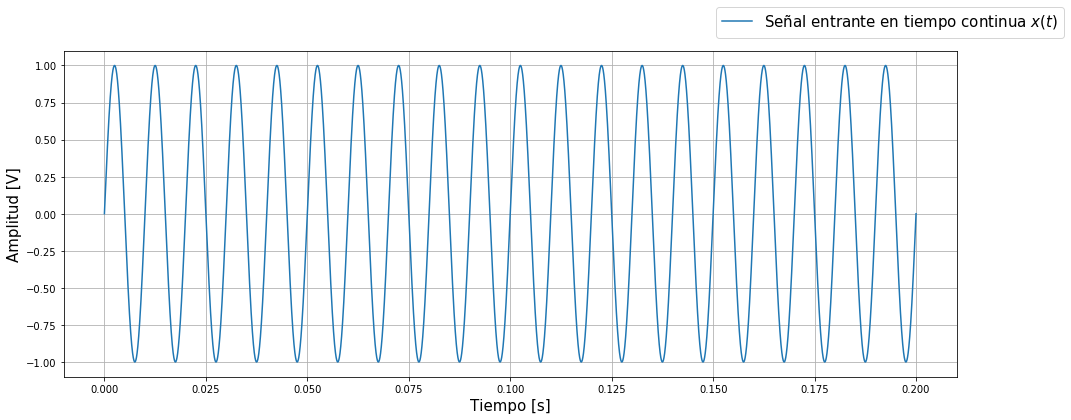

In [124]:
from matplotlib import pyplot

# Computo la señal en tiempo continuo, y un premuestreo interno para tener todo
# ya preparado, así el manejo a lo largo del programa no se vuelve medio mezclado por cómo
# se manejan los instantes y las muestras.
x = ContinuousSignal(x_t, fs, samples, count)

# Graficamos la forma temporal de la señal que estamos utilizando
t_values, x_values = x.continuous()

fig, ax = pyplot.subplots(1, 1)
fig.set_figwidth(16)
fig.set_figheight(6)

ax.plot(t_values, x_values, label="Señal entrante en tiempo continua $x(t)$")
ax.set_xlabel("Tiempo [s]", fontsize=15)
ax.set_ylabel("Amplitud [V]", fontsize=15)
ax.grid()

fig.legend(fontsize=15)

pyplot.show()

### 1. Filtro Antialias
Se realiza el filtrado con un filtro antialias, pasabajos, que limita el espectro de la señal de entrada al sistema
para evitar que se produzca aliasing. Particularmente, el uso de oversampling con una frecuencia muy elevada permite aumentar la banda de transición lo cual disminuye la pendiente requerida, por ende esta etapa puede ser conseguida con filtros de orden reducido. Esto resulta una ventaja por sobre las condiciones normales, que requieren hacer uso de filtro de mucha selectividad por el rango acotado de la banda de transición cuando se toma una frecuencia en el orden establecido por el criterio de Nyquist.

En el caso de necesitar un filtro de primer orden, se utilizaría una expresión sencilla como:

\begin{align}
    & H_{FAA}(s) = \frac{1}{1 + s \cdot R \cdot C} = \frac{1}{1 + \frac{s}{\omega_o}}  \\
    & H_{FAA}(w) = \frac{1}{1 + j \cdot \frac{\omega}{\omega_o}} \Rightarrow |H_{FAA}(\pi \cdot f_s)| = \frac{1}{\sqrt{1 + (\frac{f_s}{f_o \cdot 2})^{2}}} \Rightarrow |H_{FAA}(\pi \cdot f_s)| [dB] = -10 \cdot log(1 + (\frac{f_s}{f_o \cdot 2})^{2}) = -A_a
\end{align}

\begin{equation}
    f_o = \frac{f_s}{2} \cdot \frac{1}{\sqrt{10^{\frac{A_a}{10}} - 1}}
\end{equation}

En el caso de necesitar un orden mayor, se propone hacer uso de Butterworth, pues el filtro no debe ser demasiado selectivo. En este sentido, también podría aprovecharse la baja selectividad para utilizar un filtro Gaussiano o Bessel, para disminuir la distorsión por fase no lineal, y tener un mejor control del retardo de grupo. En otros escenarios, limitarse a la frecuencia de Nyquist podría provocar que la alta selectividad nos impida hacer uso de un Bessel, pero esto es posible gracias al oversampling.

In [125]:
def first_order_pole(fs: float, aa: float) -> float:
    """ Se calcula la ubicación del polo del sistema de primer orden para lograr
        atenuar por debajo de lo requerido en el límite de la condición de Nyquist.
        Creemos recomendable revisar luego que la ubicación mantenga cierta coherencia
        con la ubicación de la banda pasante, es decir está en una frecuencia posterior.
        @param fs: Frecuencia de muestreo
        @param aa: Atenuación mínima en banda atenuante
        @return: Frecuencia del polo de primer orden que cumple requisitos
    """
    return (fs / 2) * ( 1 / np.sqrt(10 ** (aa / 10) - 1) )

def estimate_order(fp: float, fs: float, aa: float) -> int:
    """ Estimamos el orden necesario de filtro, suponiendo que será un Butterworth,
        pues la pendiente es una función lineal del orden empleado.
        @param fp: Frecuencia de banda de paso
        @param fs: Frecuencia de muestreo
        @param aa: Atenuación deseada
        @return: Orden necesario
    """
    return np.ceil((aa / np.log10((fs / 2) / fp)) / 20)

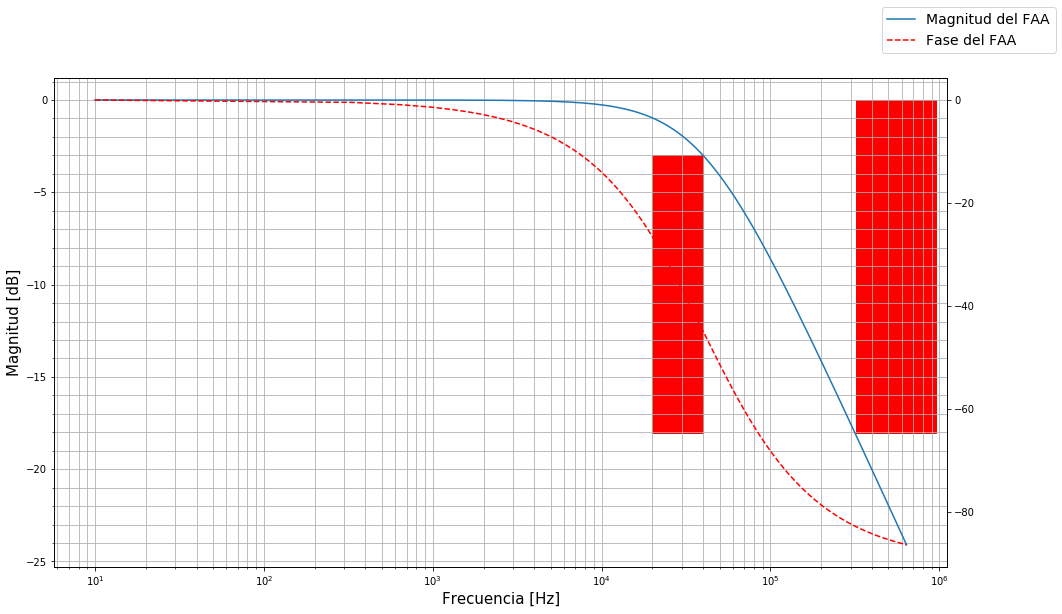

In [126]:
from scipy import signal
from matplotlib import pyplot
from matplotlib import patches

# Usamos al buen Butter para calcularnos unos cuantos polos para el FAA
order = estimate_order(fp, fs, aa)
zeros, poles, gain = signal.buttap(order)

poles = 2 * np.pi * fp * poles
gain = -1
for pole in poles:
    gain *= pole

# Construyo el filtro
faa = signal.ZerosPolesGain(zeros, poles, gain)

# Observemos la respuesta en frecuencia del filtro para cerciorarnos de su funcionamiento
f = np.arange(fin / 10, fs, (fs - fin / 10) / 2000)
w, mag, phase = faa.bode(f * 2 * np.pi)

fig, ax = pyplot.subplots(1, 1)
fig.set_figwidth(16)
fig.set_figheight(9)

ax2 = ax.twinx()
ax2.semilogx(w / (2 * np.pi), phase, label="Fase del FAA", linestyle="dashed", color="red")

ax.semilogx(w / (2 * np.pi), mag, label="Magnitud del FAA")
ax.set_xlabel("Frecuencia [Hz]", fontsize=15)
ax.set_ylabel("Magnitud [dB]", fontsize=15)
ax.minorticks_on()
ax.grid(which="both")

fig.legend(fontsize=14)

ax.add_patch(
    patches.Rectangle(
        (fp / 2, -aa),
        fp - fp / 2, aa - 3,
        color="red"
    )
)

ax.add_patch(
    patches.Rectangle(
        (fs / 2, -aa),
        fs, aa,
        color="red"
    )
)

pyplot.show()

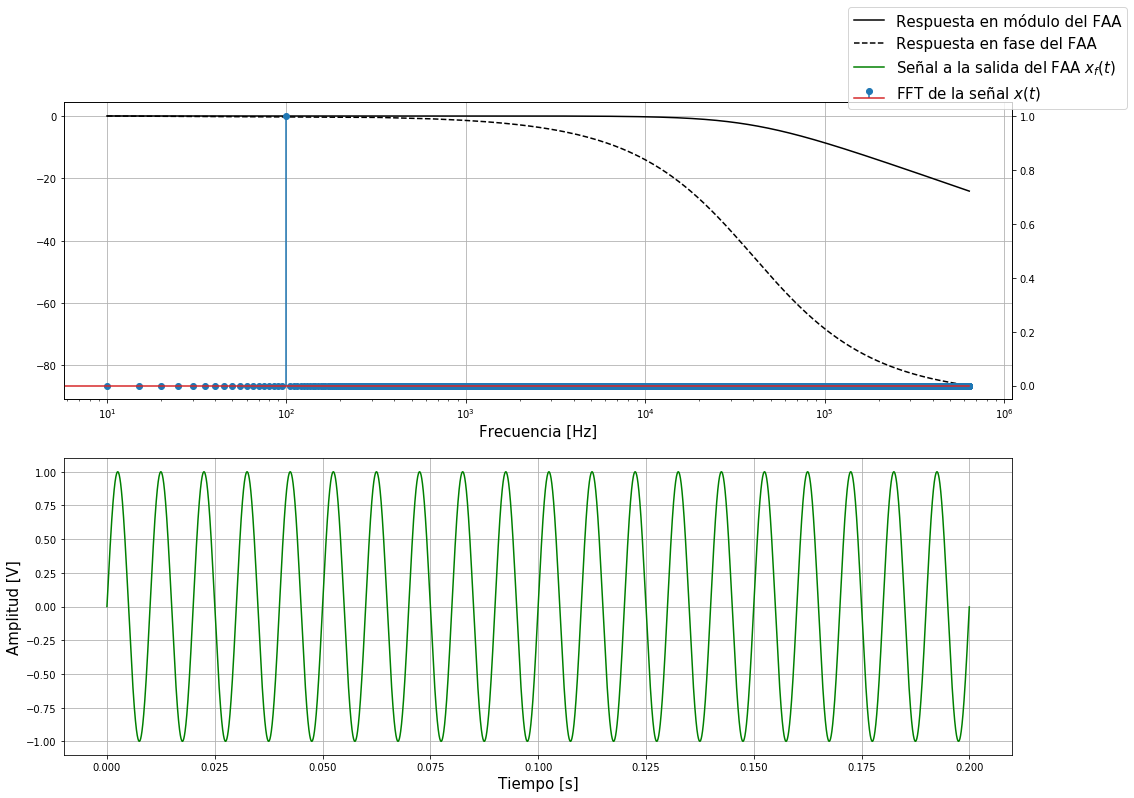

In [127]:
from scipy import fft

# Aplicamos el filtro sobre la señal continua, obviamente esta simulación que estamos haciendo mediante ContinuousSignal
# con sus puntos adicionales es lo que lo permite, el objetivo principal es poder observar un poco la ventaja de tener
# un filtro FAA de banda de transición tan amplia.
t_values, x_f_values, _ = faa.output(x_values, t_values)
x_f = ContinuousSignal.build_from_continuous(t_values, x_f_values, fs, samples, count)

# Calculo la fft de la señal de entrada, de esta forma lo que se busca es observar su espectro,
# y superponerlo sobre el FAA para poder apreciar la posible discriminación en la salida frente a sus armónicos
X = fft.fft(x_values)
X = [2 * abs(X[i]) / len(x_values) for i in range(len(X) // 2)]
f = [i / (x.step * len(x_values)) for i in range(len(X))]
stopIndex = int(fs * len(x_values) * x.step)

fig, (ax1, ax2) = pyplot.subplots(2, 1)
fig.set_figwidth(17)
fig.set_figheight(12)

ax1.plot(w / (2 * np.pi), mag, label="Respuesta en módulo del FAA", color="black")
ax1.plot(w / (2 * np.pi), phase, label="Respuesta en fase del FAA", linestyle="dashed", color="black")
ax1.set_xlabel("Frecuencia [Hz]", fontsize=15)
ax1.set_xscale("log")
ax1.grid()

ax3 = ax1.twinx()
ax3.stem(
    f[:stopIndex],
    X[:stopIndex], 
    label="FFT de la señal $x(t)$",
    use_line_collection=True
)

ax2.plot(t_values, x_f_values, label="Señal a la salida del FAA $x_f(t)$", color="green")
ax2.set_xlabel("Tiempo [s]", fontsize=15)
ax2.set_ylabel("Amplitud [V]", fontsize=15)
ax2.grid()

fig.legend(fontsize=15)

pyplot.show()

### 2. Muestreo
Se realiza un muestreo de la señal de entrada con una frecuencia ya configurada anteriormente. La frecuencia corresponde al oversampling, en el cual se emplea una frecuencia mucho mayor en una proporción establecida:

\begin{equation}
    f_s = L \cdot f_{Nyquist}
\end{equation}

Donde luego, dado que el proceso requiere realizar un downsampling para obtener la $N$ cantidad de bits, respetando la frecuencia del criterio de Nyquist, en un caso límite sucede que:

\begin{equation}
    L = 2^{N}
\end{equation}

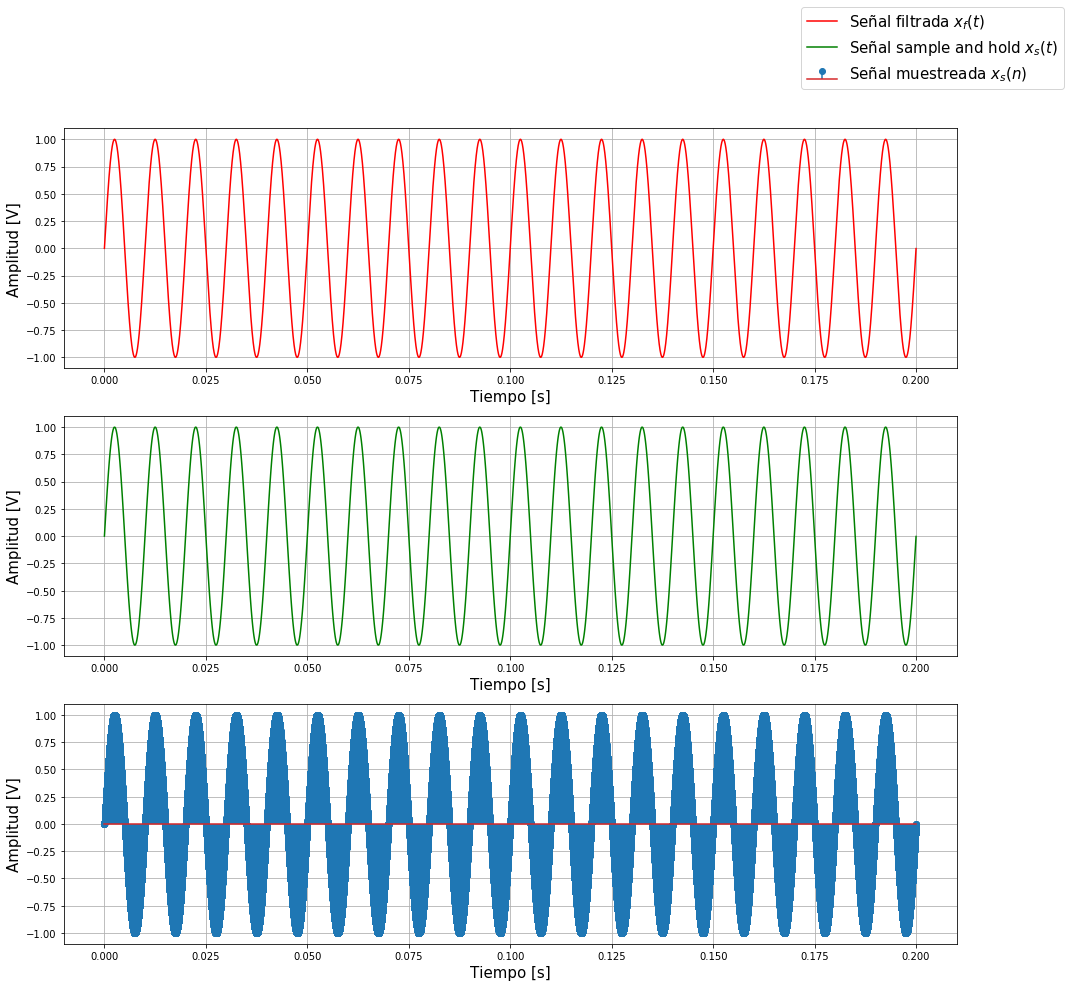

In [128]:
# Calculamos las muestras
t_sh_values, x_sh_values = x_f.instantaneous_sampling()
t_s_values, x_s_values = x_f.discrete_sampling()

# Realizamos ambos graficos
fig, (ax1, ax2, ax3) = pyplot.subplots(3, 1)

fig.set_figheight(15)
fig.set_figwidth(16)

ax1.plot(t_values, x_f_values, label="Señal filtrada $x_f(t)$", color="red")
ax1.grid()
ax1.set_ylabel("Amplitud [V]", fontsize=15)
ax1.set_xlabel("Tiempo [s]", fontsize=15)

ax2.plot(t_sh_values, x_sh_values, label="Señal sample and hold $x_s(t)$", color="green")
ax2.grid()
ax2.set_ylabel("Amplitud [V]", fontsize=15)
ax2.set_xlabel("Tiempo [s]", fontsize=15)

ax3.stem(t_s_values, x_s_values, label="Señal muestreada $x_s(n)$", use_line_collection=True)
ax3.grid()
ax3.set_ylabel("Amplitud [V]", fontsize=15)
ax3.set_xlabel("Tiempo [s]", fontsize=15)

fig.legend(fontsize=15)

pyplot.show()

### 3. Conversor Sigma Delta
Se implementa la conversión sigma delta de primer orden, al cual se puede modelar trabajando en tiempo discreto realizando la transformada Z, y obtener así la forma equivalente del mismo:

<img width=840 src="sigmadelta_discrete.png"></img>

De esto, aplicando superposición y operaciones de sistemas básicas, se puede obtener que la salida se compone de la siguiente expresión:

\begin{equation}
    Y(z) = X(z) \cdot z^{-1} + N(z) \cdot (1 - z^{-1}) 
\end{equation}

De esto resulta evidente observar que la entrada tiene aplicada un filtro pasabajos, mientras que el ruido de cuantización tiene aplicado un pasaaltos. Esta es una de las fuertes ventajas que posee este proceso de modulación ya que garantiza que para un rango acotado de bajas frecuencias la contribución del ruido de cuantización se ve disminuída fuertemente, de esta forma si la frecuencia de oversampling es lo suficientemente grande este rango cae sobre la banda de interés de entrada provocando así que la relación SQNR se vea aumentada. De esta forma, se puede llegar a una nueva expresión de SQNR para estos conversores:

\begin{equation}
    SQNR = 6.02dB \cdot (n + 1.5 \cdot log_2(L)) - 3.41dB
\end{equation}

Esta expresión es genérica en sentido que incorpora la opción mencionada anteriormente donde n, L no se encuentran vinculados estrictamente, porque podría bajarse la frecuencia de muestreo a una superior a la de Nyquist.

In [129]:
def sigma_delta(x: np.array) -> np.array:
    """ Se simula el proceso de un conversor Sigma Delta sobre el buffer o array
        de datos pre muestreados en las etapas previas.
        @param x: Arreglo de muestras tomadas de la señal con frecuencia de oversampling
        @return: Devuelve el arreglo de '1' y '0' correspondiente a la cuantización del Sigma Delta.
    """
    
    def quantization(xi: float) -> int:
        """ Bloque de cuantización, defino convención de salida del ADC.
            @param xi: Error acumulado, salida del integrador
            @return: Estado '1' o '0'
        """
        return 1 if xi > 0 else 0
    
    def dac(y: int, a: float) -> float:
        """ Bloque de dac, para la comparación la entrada y acumulación de error.
            @param y: Estado de salida actual
            @param a: Tensión de referencia del DAC
            @return: Devuelve su conversión a analogico
        """
        return (1 if y == 1 else -1) * a

    # Inicializo vector de salida, sistema relajado!
    out = np.zeros((len(x)))
    
    # Defino el error acumulado en la integral
    xi = 0
    
    for i in range(len(x)):
        # Se calcula la señal de error, resta entre entrada y estado de salida actual
        e = x[i] - (dac(out[i - 1], vref) if i > 0 else 0)
        
        # Acumulo el error
        xi += e
        
        # Genero la salida actual
        out[i] = quantization(xi)
    
    return out

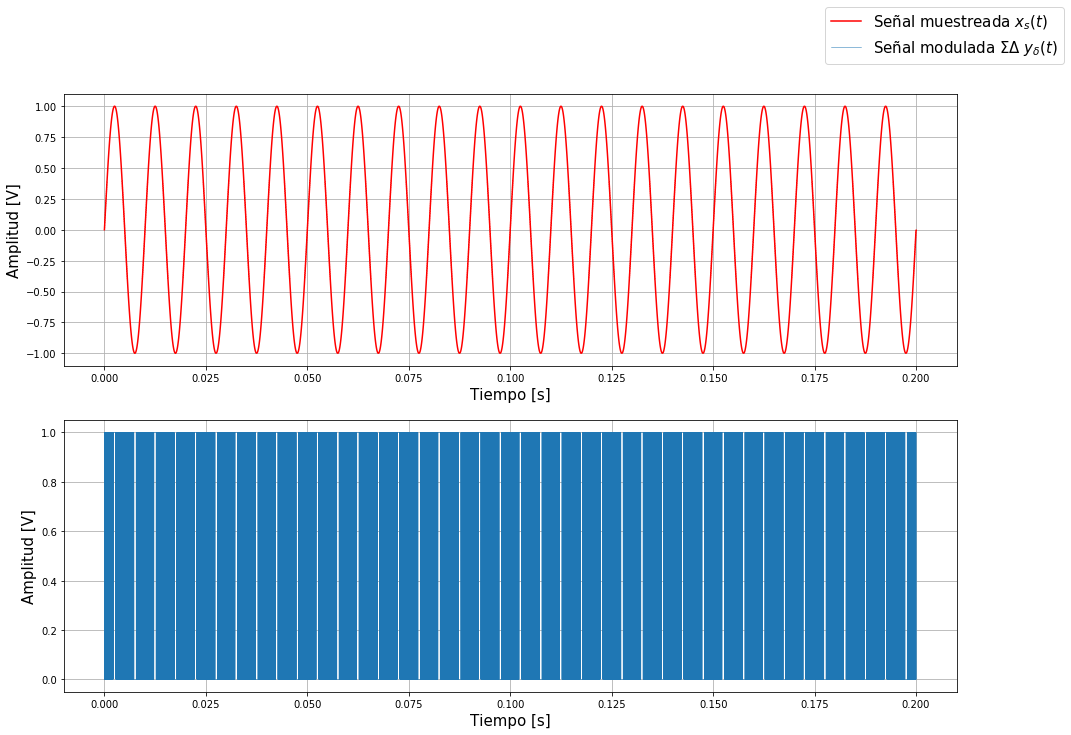

In [130]:
# Aplicamos el proceso de la conversión sigma delta sobre la señal correspondiente
# a la salida del sample and hold. Como debería ser un proceso sincronizado con el clock de muestreo
# para que la iteración de la realimentación sea controlado por estos tiempos, se hace sobre la señal discreta.
y_d = ContinuousSignal.build_from_discrete(sigma_delta(x_s_values), fs, samples, count)
t_d_values, y_d_values = y_d.continuous()

# Realizamos ambos graficos
fig, (ax1, ax2) = pyplot.subplots(2, 1)

fig.set_figheight(11)
fig.set_figwidth(16)

ax1.plot(t_sh_values, x_sh_values, label="Señal muestreada $x_s(t)$", color="red")
ax1.grid()
ax1.set_ylabel("Amplitud [V]", fontsize=15)
ax1.set_xlabel("Tiempo [s]", fontsize=15)

ax2.plot(t_d_values, y_d_values, label="Señal modulada $\Sigma \Delta$ $y_{\delta}(t)$", linewidth=0.5)
ax2.grid()
ax2.set_ylabel("Amplitud [V]", fontsize=15)
ax2.set_xlabel("Tiempo [s]", fontsize=15)

fig.legend(fontsize=15)

pyplot.show()

### 4. FIR: Filtro pasabajos
En esta etapa, conceptualmente dentro del DSP, se aplica un filtro pasabajos FIR, con coeficientes unitarios, de longitud dada como $M = 2^{N}$ donde $N$ es la cantidad de bits resultantes del ADC. El objetivo es realizar un promedio de las muestras obtenidas como resultado de la modulación $\Sigma \Delta$, donde podemos pensar este resultado como la cuantización. Esto último resulta de tener en cuenta que:

\begin{equation}
    y_f(n) \in {0, ..., \frac{i}{2^{N}}, ..., 1}, 0 \leq i \leq M - 1
\end{equation}

In [131]:
class FIR:
    """ Se crea un filtro FIR que se implementa como ecuación de recurrencia, guardando los coeficientes
        de la misma.
        @param coef: Lista, array de coeficientes. Si se omiten deben dejarse espacios en 0.
            y(n) = a0.x(n) + a1.x(n-1) + ... + ai.x(n-i)
                    => coef = [a0, ..., ai]
    """
    def __init__(self, coef):
        # Se guardan los coeficientes
        self._a = coef
    
    def filter(self, x):
        """ Aplica el filtro FIR con los coeficientes configurados en su construcción sobre la señal
            de entrada.
            @param x: Señal de entrada
            @return: Salida filtrada
        """
        y = np.zeros(len(x))
        for i in range(len(y)):
            for j, a_j in enumerate(self._a):
                y[i] += a_j * x[i - j] if (i - j) >= 0 else 0
        return y

In [132]:
# Construyo mi filtro FIR
fir = FIR([1 for i in range(l)])

# Aplicamos el filtro FIR sobre las muestras obtenidas como la modulación sigma delta
t_sd_values, y_sd_values = y_d.discrete_sampling()
y_f = ContinuousSignal.build_from_discrete(fir.filter(y_sd_values), fs, samples, count)

### 5. Downsampling
Se reduce la tasa de muestreo original a la frecuencia de Nyquist para la banda de paso utilizada, y considerando que inicialmente fue muestreada a una frecuencia superior esto podría implicar peligro de producir aliasing, pero con el uso del filtro FIR se limitó la banda para garantizar no ocurra esto.

\begin{equation}
    y(n) = y_f(n \cdot 2^{N})
\end{equation}

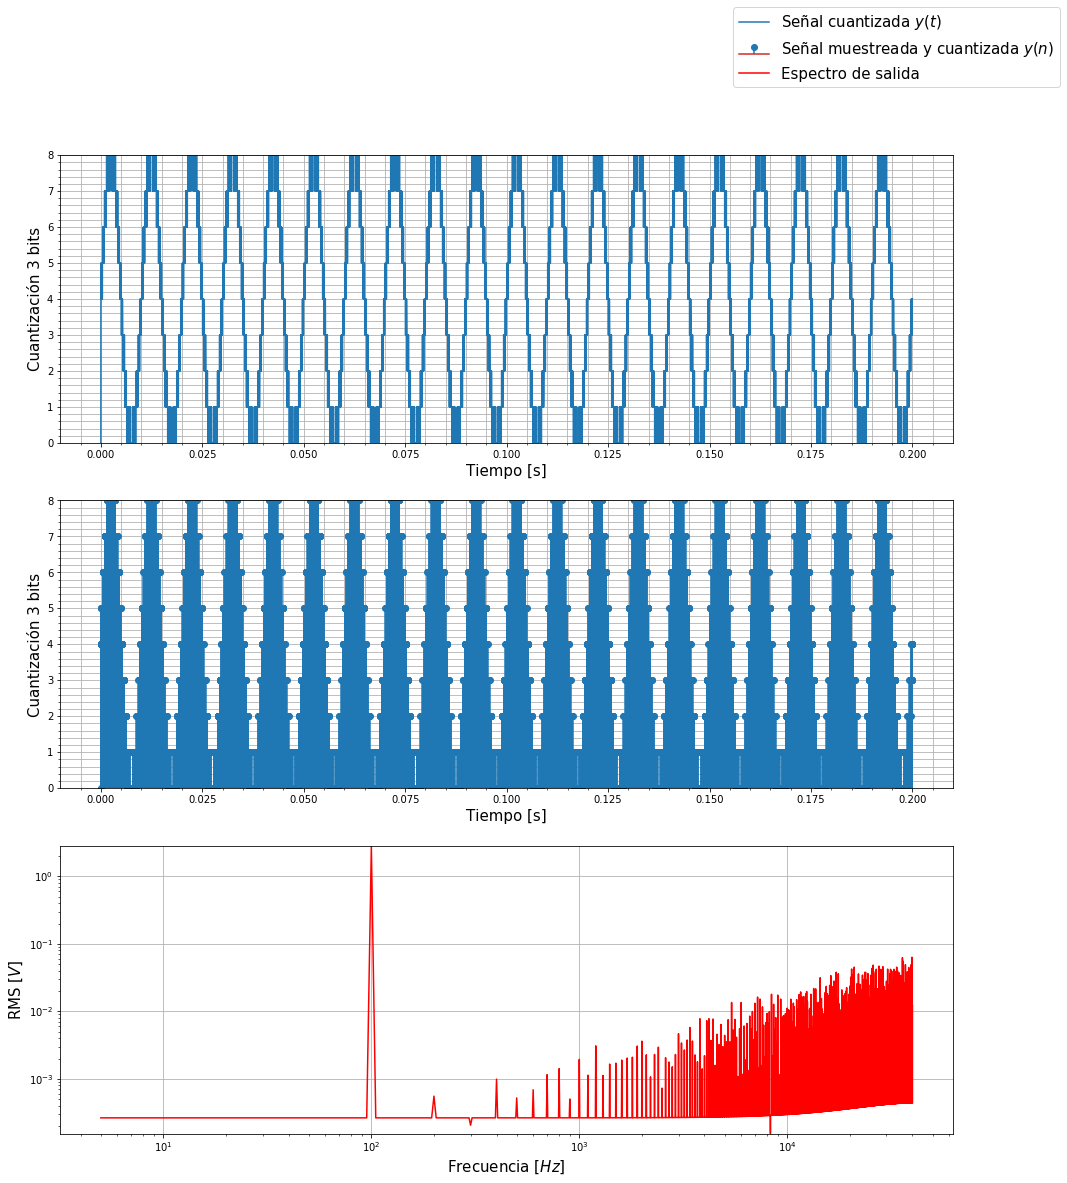

In [133]:
from scipy import signal
from matplotlib import pyplot

# Realizo el downsampling con el codigo ya preparado para ello...
y = y_f.downsample(l)
t_n_values, y_n_values = y.continuous()
t_n_s_values, y_n_s_values = y.discrete_sampling()

# Calculo con el periodogram de Scipy, el espectro de salida del sistema
# se eliminó el primer elemento porque así se busca que quede bien escalado
f, pxx = signal.periodogram(y_n_s_values, window='rectangular', fs=fp*2, scaling='spectrum')
pxx = np.sqrt(pxx[1:])
f = f[1:]

# Realizo el grafico
fig, (ax1, ax2, ax3) = pyplot.subplots(3, 1)

fig.set_figwidth(16)
fig.set_figheight(18)

ax1.plot(t_n_values, y_n_values, label="Señal cuantizada $y(t)$")
ax1.set_xlabel("Tiempo [s]", fontsize=15)
ax1.set_ylabel(f"Cuantización {n} bits", fontsize=15)
ax1.set_ylim(0, l)
ax1.minorticks_on()
ax1.grid(which="both")

ax2.stem(t_n_s_values, y_n_s_values, label="Señal muestreada y cuantizada $y(n)$", use_line_collection=True)
ax2.set_xlabel("Tiempo [s]", fontsize=15)
ax2.set_ylabel(f"Cuantización {n} bits", fontsize=15)
ax2.set_ylim(0, l)
ax2.minorticks_on()
ax2.grid(which="both")

ax3.plot(f, pxx, color='red', label="Espectro de salida")
ax3.set_ylabel("RMS $[V]$", fontsize=15)
ax3.set_xlabel("Frecuencia $[Hz]$", fontsize=15)
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.min(pxx), np.max(pxx))
ax3.grid()

fig.legend(fontsize=15)

pyplot.show()

### Observaciones y conclusiones

1. La señal de salida del ADC, muestreada y cuantizada, posee un nivel de continua si es que puede ser dicho de esta forma. Esto se debe a que la salida del cuantizador de un bit posee ese nivel de continua, y provoca que luego las señales cuantizadas tengan su $0v$ ubicado en la representación binaria de $2^{N-1}$.

2. Se puede observar en el espectro resultante la presencia de ruido proveniente del proceso de cuantización, que particularmente por las características del modulador $\Sigma \Delta$ no se encuentra uniformemente distribuído, sino que
para bajas frecuencias se encuentra atenuado, y resulta de interés observar que para el rango de frecuencias de interés original, la relación señal a ruido mejoro notablemente con respecto a un escenario de cuantización ordinario. 